# Model evaluation

After you've trained several models, you may want to generate some accuracy metrics to compare between them. This notebook demonstrates how you'll do that given a trained model.

Let's start by installing SLEAP and downloading the trained model.

In [ ]:
!pip uninstall -y opencv-python opencv-contrib-python > /dev/null 2>&1
!pip install sleap > /dev/null 2>&1
!apt install tree > /dev/null 2>&1
#!wget https://storage.googleapis.com/sleap-data/reference/flies13/td_fast.210505_012601.centered_instance.n%3D1800.zip > /dev/null 2>&1
#!unzip -o -d "td_fast.210505_012601.centered_instance.n=1800" "td_fast.210505_012601.centered_instance.n=1800.zip" > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


A trained SLEAP model will be a folder containing files that specify metadata that is useful for evaluation and analysis. The exact set of files may depend on the configuration, but all models will come with:

- `metrics.train.npz`: Metrics for the training split.
- `metrics.val.npz`: Metrics for the validation split. This is what you'll want to use most of the time since it wasn't directly used for optimizing the model.

**Note:** A test split will also be evaluated if it was provided during training and saved to `metrics.test.npz`.

In [ ]:
!tree /content/drive/MyDrive/COCOHorseSleapPose/models/230513_124413.centered_instance

/content/drive/MyDrive/COCOHorseSleapPose/models/230513_124413.centered_instance
├── best_model.h5
├── initial_config.json
├── labels_gt.train.slp
├── labels_gt.val.slp
├── labels_pr.train.slp
├── labels_pr.val.slp
├── metrics.train.npz
├── metrics.val.npz
├── training_config.json
└── training_log.csv

0 directories, 10 files


Additionally, the following files are included and may also be useful:
- `best_model.h5`: The actual saved model and weights. This can be loaded with `tf.keras.model.load_model()` but it is recommended to use `sleap.load_model()` instead as it takes care of adding some additional inference-only procedures.
- `training_config.json`: The configuration for the model training job, including metadata inferred during the training procedure. It can be loaded with `sleap.load_config()`.
- `labels_gt.train.slp` and `labels_pr.train.slp`: These are SLEAP labels files containing the ground truth and predicted points for the training split. They do not contain the images, but can be used to retrieve the poses used.
- `labels_gt.val.slp` and `labels_pr.val.slp`: These are SLEAP labels files containing the ground truth and predicted points for the validation split. They do not contain the images, but can be used to retrieve the poses used.

In [ ]:
import sleap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use("seaborn-deep")
sleap.versions()

SLEAP: 1.3.1
TensorFlow: 2.8.4
Numpy: 1.22.4
Python: 3.10.12
OS: Linux-5.15.107+-x86_64-with-glibc2.31


<ipython-input-4-3e2d51a85cd8>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-deep")


SLEAP metrics can be loaded using the `sleap.load_metrics()` API:

In [ ]:
help(sleap.load_metrics)

Help on function load_metrics in module sleap.nn.evals:

load_metrics(model_path: str, split: str = 'val') -> typing.Dict[str, typing.Any]
    Load metrics for a model.
    
    Args:
        model_path: Path to a model folder or metrics file (.npz).
        split: Name of the split to load the metrics for. Must be `"train"`, `"val"` or
            `"test"` (default: `"val"`). Ignored if a path to a metrics NPZ file is
            provided.
    
    Returns:
        The loaded metrics as a dictionary with keys:
    
        - `"vis.tp"`: Visibility - True Positives
        - `"vis.fp"`: Visibility - False Positives
        - `"vis.tn"`: Visibility - True Negatives
        - `"vis.fn"`: Visibility - False Negatives
        - `"vis.precision"`: Visibility - Precision
        - `"vis.recall"`: Visibility - Recall
        - `"dist.avg"`: Average Distance (ground truth vs prediction)
        - `"dist.p50"`: Distance for 50th percentile
        - `"dist.p75"`: Distance for 75th percentile
  

Loading the metrics for the validation split of the model we can see all of the available keys:

In [ ]:
metrics = sleap.load_metrics("/content/drive/MyDrive/COCOHorseSleapPose/models/230513_124413.centered_instance", split="val")
print("\n".join(metrics.keys()))

vis.tp
vis.fp
vis.tn
vis.fn
vis.precision
vis.recall
dist.dists
dist.avg
dist.p50
dist.p75
dist.p90
dist.p95
dist.p99
pck.thresholds
pck.pcks
pck.mPCK_parts
pck.mPCK
oks.mOKS
oks_voc.match_score_thresholds
oks_voc.recall_thresholds
oks_voc.match_scores
oks_voc.precisions
oks_voc.recalls
oks_voc.AP
oks_voc.AR
oks_voc.mAP
oks_voc.mAR
pck_voc.match_score_thresholds
pck_voc.recall_thresholds
pck_voc.match_scores
pck_voc.precisions
pck_voc.recalls
pck_voc.AP
pck_voc.AR
pck_voc.mAP
pck_voc.mAR


To start, let's look at the summary of the **localization errors**:

In [ ]:
print("Error distance (50%):", metrics["dist.p50"])
print("Error distance (90%):", metrics["dist.p90"])
print("Error distance (95%):", metrics["dist.p95"])

Error distance (50%): 4.021887539632914
Error distance (90%): 14.307574612207535
Error distance (95%): 22.949193553101882


These are the percentiles of the distribution of how far off the model was from the ground truth location.

We can visualize the entire distribution like this:

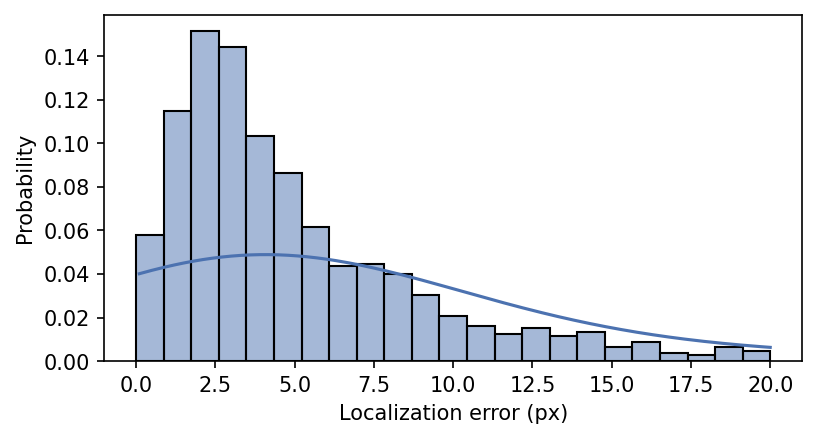

In [ ]:
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics["dist.dists"].flatten(), binrange=(0, 20), kde=True, kde_kws={"clip": (0, 20)}, stat="probability")
plt.xlabel("Localization error (px)");

This metric is intuitive, but it does not incorporate other sources of error like those stemming from poor instance detection and grouping, or missing points.

The Object Keypoint Similarity (OKS) is a more holistic metric that takes factors such as landmark visibility, animal size, and the difficulty in locating keypoints (all are assumed to be "easy" for our calculations). You can read more about this and other pose estimation metrics in: https://arxiv.org/abs/1707.05388

First let's plot the distribution of OKS scores:

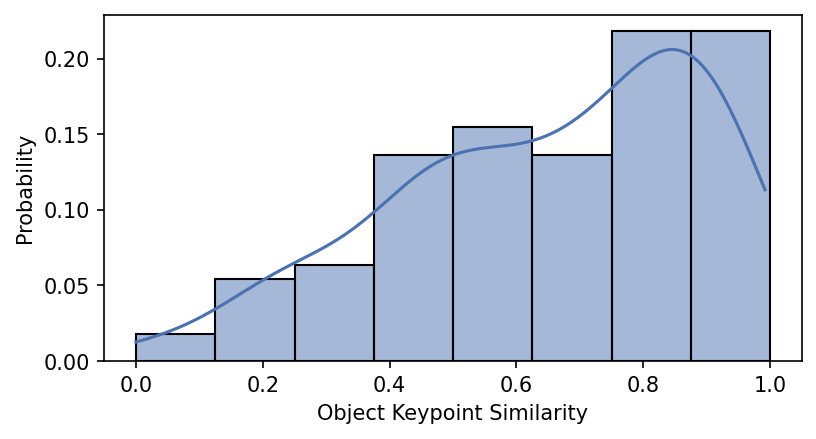

In [ ]:
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics["oks_voc.match_scores"].flatten(), binrange=(0, 1), kde=True, kde_kws={"clip": (0, 1)}, stat="probability")
plt.xlabel("Object Keypoint Similarity");

Since these range from 0 to 1, it seems like we're doing pretty well!

Another way to summarize this is through precision-recall curves, which evaluate how well the model does at different thresholds of OKS scores. The higher the threshold, the more stringent our criteria for classifying a prediction as correct.

Here we plot this at different thresholds:

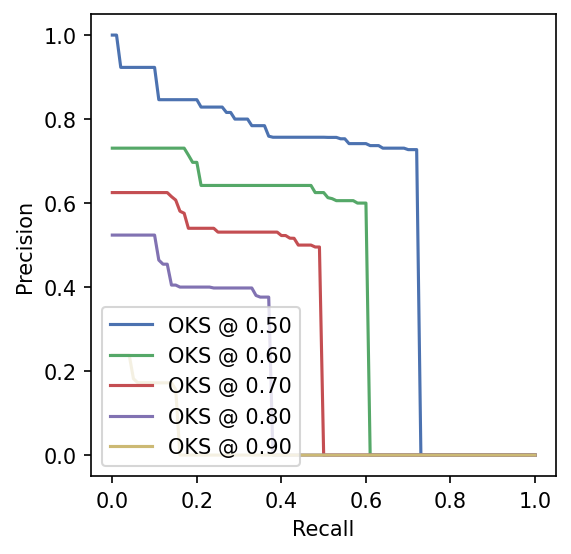

In [ ]:
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")
for precision, thresh in zip(metrics["oks_voc.precisions"][::2], metrics["oks_voc.match_score_thresholds"][::2]):
    plt.plot(metrics["oks_voc.recall_thresholds"], precision, "-", label=f"OKS @ {thresh:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left");

An easy way to summarize this analysis is to take the average over all of these thresholds to compute the **mean Average Precision (mAP)** and **mean Average Recall (mAR)** which are widely used in the pose estimation literature.

Here are those values saved out:

In [ ]:
print("mAP:", metrics["oks_voc.mAP"])
print("mAR:", metrics["oks_voc.mAR"])

mAP: 0.26010410843036824
mAR: 0.43636363636363634


Great, but what if we have some new labels or want to evaluate the model with an updated set of labels for better comparisons with newer models?

For this, we'll need to generate new predictions.

First, let's download a new SLEAP labels package file (`.pkg.slp`). This is important since it denotes that the labels contain the images as well which we need for predicting.

In [ ]:
!wget https://storage.googleapis.com/sleap-data/datasets/wt_gold.13pt/tracking_split2/test.pkg.slp > /dev/null 2>&1

Next we can simply load the model, the ground truth (GT) labels, and generate the predictions (~1 min on CPU):

In [ ]:
predictor = sleap.load_model("/content/drive/MyDrive/COCOHorseSleapPose/models/230513_124413.centered_instance")
labels_gt = sleap.load_file("/content/drive/MyDrive/COCOHorseSleapPose/TrainJopPgk/HorseCOCO.pkg.slp")
labels_pr = predictor.predict(labels_gt)

Output()

Generating another set of metrics can then be calculated with the pair of GT and predicted labels:

In [ ]:
metrics = sleap.nn.evals.evaluate(labels_gt, labels_pr)
metrics

{'vis.tp': rec.array(13219,
           dtype=int64),
 'vis.fp': rec.array(331,
           dtype=int64),
 'vis.tn': rec.array(10923,
           dtype=int64),
 'vis.fn': rec.array(827,
           dtype=int64),
 'vis.precision': rec.array(0.97557196,
           dtype=float64),
 'vis.recall': rec.array(0.94112203,
           dtype=float64),
 'dist.dists': array([[        nan,         nan,         nan, ...,  5.91025547,
         26.94660312, 49.22693382],
        [        nan,         nan,         nan, ...,  5.93183897,
                 nan,         nan],
        [ 2.34882006,         nan,  1.6594908 , ...,  0.3675931 ,
          3.18312804,  4.75102195],
        ...,
        [ 3.69923196,         nan,  3.51419354, ...,  2.10837476,
          1.82956532,  0.7662597 ],
        [        nan,         nan,         nan, ...,         nan,
          3.62008099,  1.61258256],
        [        nan,         nan,         nan, ...,         nan,
          3.67151959,  3.42209682]]),
 'dist.avg': 3.44965

In [ ]:
metrics = sleap.nn.evals.evaluate(labels_gt, labels_pr)

print("Error distance (50%):", metrics["dist.p50"])
print("Error distance (90%):", metrics["dist.p90"])
print("Error distance (95%):", metrics["dist.p95"])
print("mAP:", metrics["oks_voc.mAP"])
print("mAR:", metrics["oks_voc.mAR"])

Error distance (50%): 2.2415500766577936
Error distance (90%): 5.5119067622804865
Error distance (95%): 7.9192803176613005
mAP: 0.6275335333156785
mAR: 0.7566243194192376
